# XGB Modeling

In [1]:
import os
import sys

from joblib import load
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

In [4]:
path_tuning = "./results_tuning"

### XGB with additional date variables and weather data

In [5]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [6]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [7]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.50
Test set, RMSE=0.50


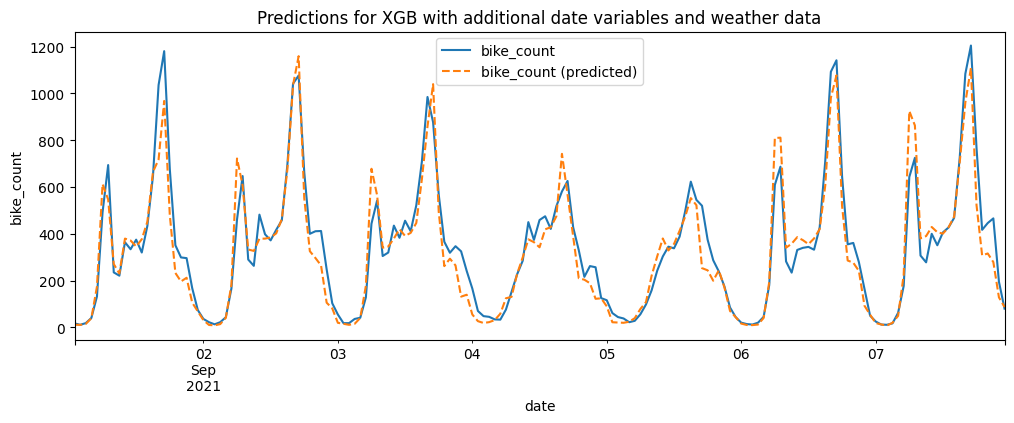

In [8]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "XGB with additional date variables and weather data",
)

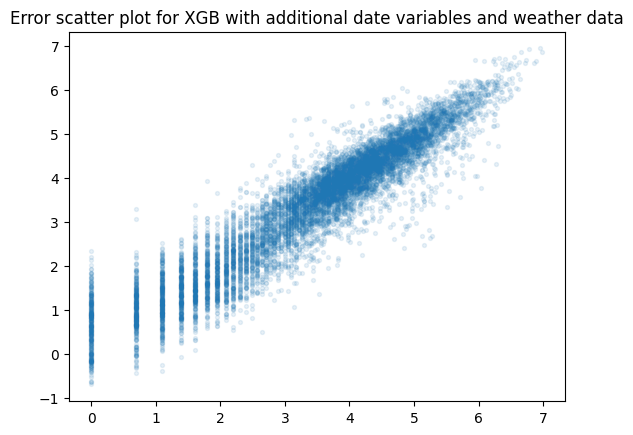

In [9]:
problem.error_plot(
    y_pred_test, y_test, "XGB with additional date variables and weather data"
)

### Tuned XGB with external data

After a first run we redefined the grid to tune on a more granular level (see following grid):
```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__colsample_bytree": [.7, .8],
        "xgbregressor__colsample_bylevel": [.7, .8],
        "xgbregressor__colsample_bynode": [.7, .8, 1.],
        "xgbregressor__max_depth": [7, 8, 9, 10],
        "xgbregressor__subsample": [.7, .8, .9],
    }
```

In [10]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_1816_tuning_xgb_cv_results.csv")
)

In [11]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'xgbregressor__colsample_bylevel': 0.7, 'xgbregressor__colsample_bynode': 0.7, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 300, 'xgbregressor__subsample': 0.7}"

In [12]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor(
    colsample_bylevel=0.7,
    colsample_bynode=0.7,
    colsample_bytree=0.7,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=300,
    subsample=0.7,
)

tuning_xgb = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_xgb.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=7, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [13]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.47
Test set, RMSE=0.50


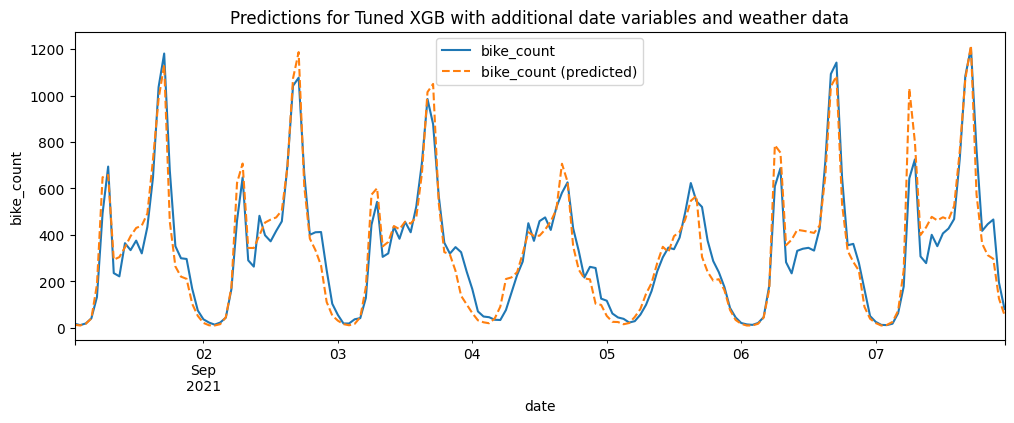

In [14]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

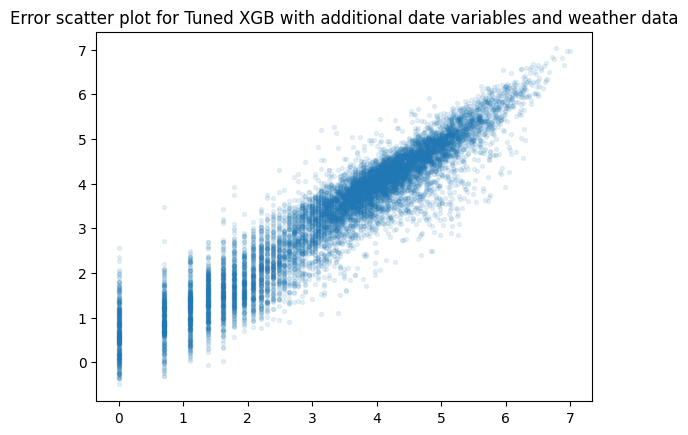

In [15]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

```
grid = {
        "xgbregressor__n_estimators": [400],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__colsample_bytree": [.5, .6, .7],
        "xgbregressor__colsample_bylevel": [.5, .6, .7],
        "xgbregressor__colsample_bynode": [.5, .6, .7],
        "xgbregressor__max_depth": [9, 10],
        "xgbregressor__subsample": [.8],
    }
```

In [16]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221120_1508_tuning_xgb_cv_results.csv")
)

In [17]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'xgbregressor__colsample_bylevel': 0.5, 'xgbregressor__colsample_bynode': 0.5, 'xgbregressor__colsample_bytree': 0.5, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 400, 'xgbregressor__subsample': 0.8}"

In [18]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor(
    colsample_bylevel=0.5,
    colsample_bynode=0.5,
    colsample_bytree=0.5,
    learning_rate=0.1,
    max_depth=9,
    n_estimators=400,
    subsample=0.8,
)

tuning_xgb = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_xgb.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=9, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=400, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [19]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.48


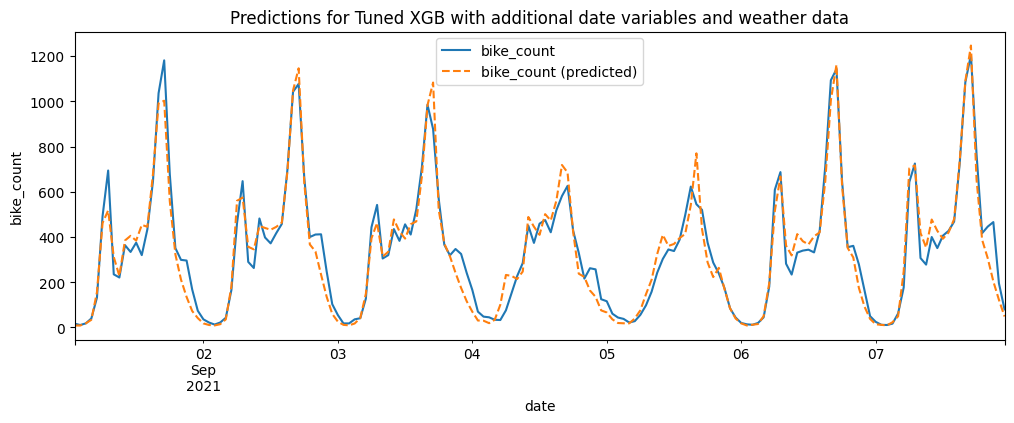

In [20]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

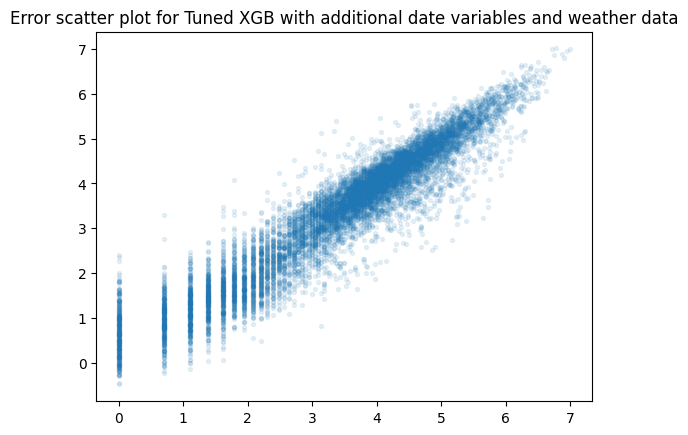

In [21]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

#### Tuning with dart
```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__booster": ["dart"],
        "xgbregressor__rate_drop": [.0, .05, .1],
        "xgbregressor__rate_drop": [0, 1],
        "xgbregressor__skip_drop": [.0, .05, .1],

        "xgbregressor__colsample_bytree": [.7, .8],
        "xgbregressor__colsample_bylevel": [.7, .8],
        "xgbregressor__colsample_bynode": [.7, .8],
        "xgbregressor__max_depth": [8, 10],
        "xgbregressor__subsample": [.7, .8],
    }
```

In [22]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_2340_tuning_xgb_cv_results.csv")
)

In [23]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'xgbregressor__booster': 'dart', 'xgbregressor__colsample_bylevel': 0.7, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 200, 'xgbregressor__rate_drop': 0.0, 'xgbregressor__skip_drop': 0.0, 'xgbregressor__subsample': 0.7}"

In [24]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor(
    booster="dart",
    colsample_bylevel=0.7,
    colsample_bytree=0.7,
    learning_rate=0.2,
    max_depth=4,
    n_estimators=200,
    rate_drop=0,
    skip_drop=0,
    subsample=0.7,
)

tuning_xgb = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_xgb.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.2, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=4, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=200, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, rate_drop=0,
                              reg_alpha=0, ...))])

In [25]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.58
Test set, RMSE=0.54


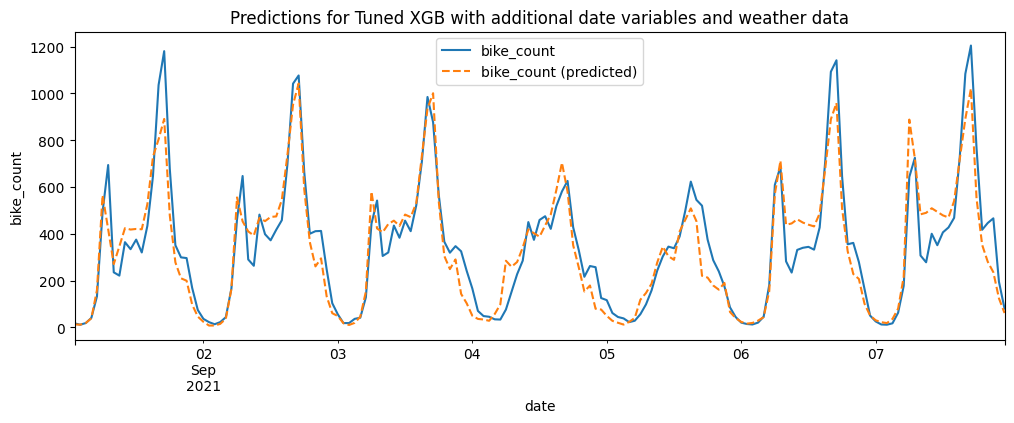

In [26]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

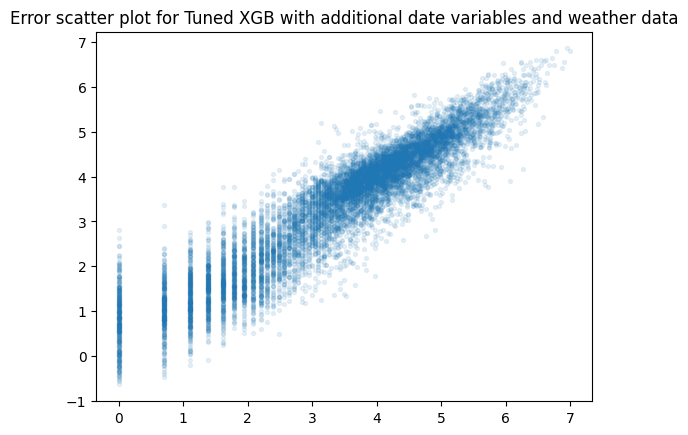

In [27]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

## Tuned XGB
We decided to remove two columns *day* and *site_name*

```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [0.1],
        "xgbregressor__colsample_bytree": [.6, .7, .8],
        "xgbregressor__colsample_bylevel": [.5, .6],
        "xgbregressor__colsample_bynode": [.6, .8],
        "xgbregressor__max_depth": [4, 6, 8, 10],
        "xgbregressor__subsample": [.6, .7, .8, .9, 1],
        "xgbregressor__min_child_weight": [1, 10],
    }
```

In [28]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221122_1844_tuning_xgb_reduced_lower_cv_results.csv")
)

In [29]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'xgbregressor__colsample_bylevel': 0.5, 'xgbregressor__colsample_bynode': 0.6, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 1, 'xgbregressor__n_estimators': 300, 'xgbregressor__subsample': 0.6}"

In [30]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor(
    colsample_bylevel=0.5,
    colsample_bynode=0.6,
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=300,
    min_child_weight=1,
    subsample=0.6,
)

tuning_xgb = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_xgb.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=4, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=300, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [31]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.65
Test set, RMSE=0.63


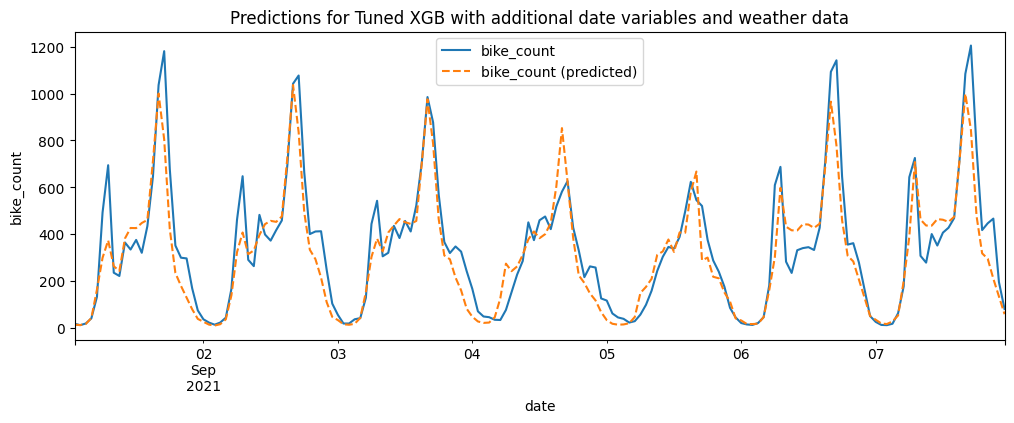

In [32]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

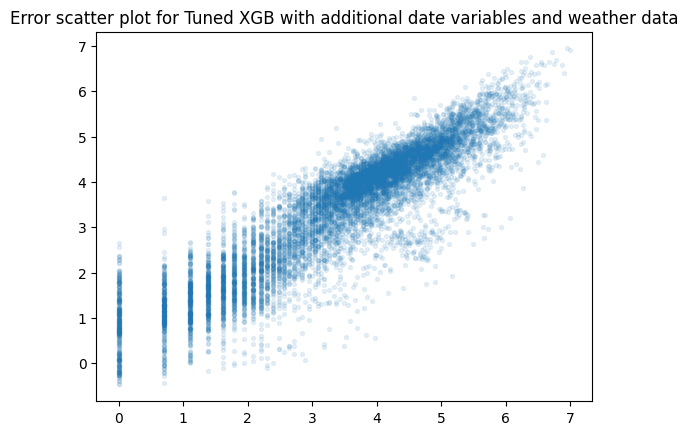

In [33]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

```
grid = {
        "xgbregressor__n_estimators": [600],
        "xgbregressor__learning_rate": [0.1],
        "xgbregressor__colsample_bytree": [.4, .5, .6,],
        "xgbregressor__colsample_bylevel": [.6, .8],
        "xgbregressor__colsample_bynode": [.8, .9],
        "xgbregressor__max_depth": [4, 6, 8, 10],
        "xgbregressor__subsample": [.6, .7, .8, .9, 1],
        "xgbregressor__min_child_weight": [1, 10],
    }
```

In [34]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221122_1858_tuning_xgb_reduced_higher_cv_results.csv")
)

In [35]:
cv_results.sort_values(by="rank_test_score").params[0]

"{'xgbregressor__colsample_bylevel': 0.6, 'xgbregressor__colsample_bynode': 0.8, 'xgbregressor__colsample_bytree': 0.4, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 1, 'xgbregressor__n_estimators': 600, 'xgbregressor__subsample': 0.6}"

In [36]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor(
    colsample_bylevel=0.6,
    colsample_bynode=0.8,
    colsample_bytree=0.4,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=600,
    min_child_weight=1,
    subsample=0.6,
)

tuning_xgb = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
tuning_xgb.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=4, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=600, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [37]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.57
Test set, RMSE=0.58


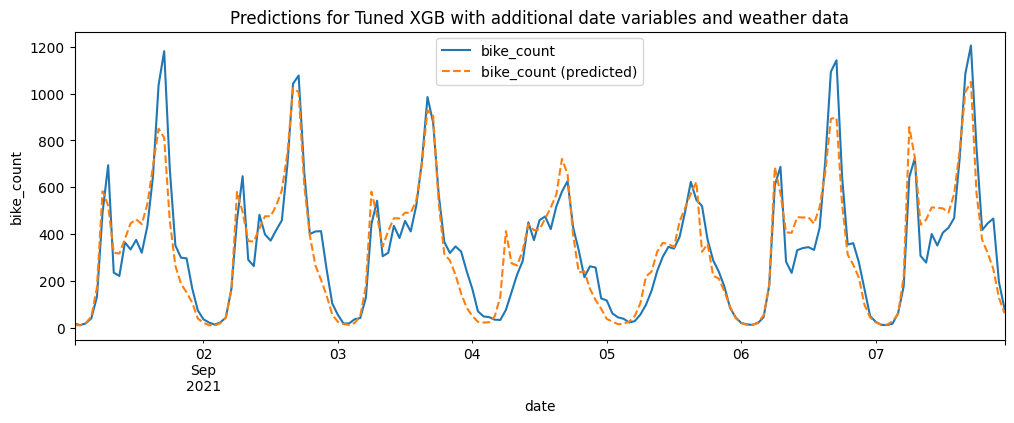

In [38]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

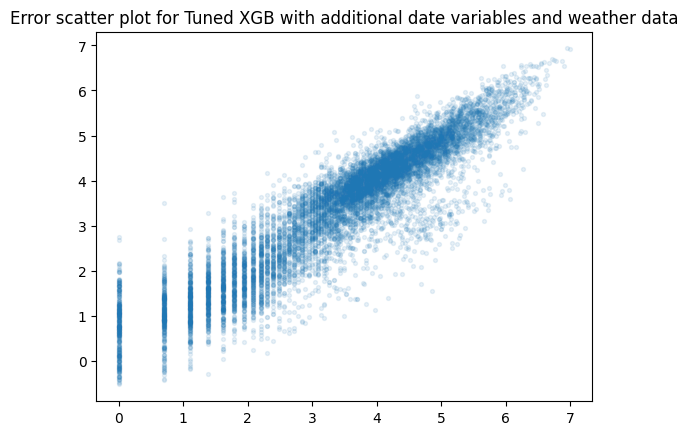

In [39]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

## Histogram-based GB

In [40]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        (
            "date",
            OneHotEncoder(handle_unknown="ignore", sparse=False),
            date_cols + add_date_cols,
        ),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
    ],
)

regressor = HistGradientBoostingRegressor(max_iter=1000)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8dda3e2280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8dda3e2160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8dda3e21f0>,
                                     kw_args={'dr...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(max_iter=1000))])

In [41]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.48


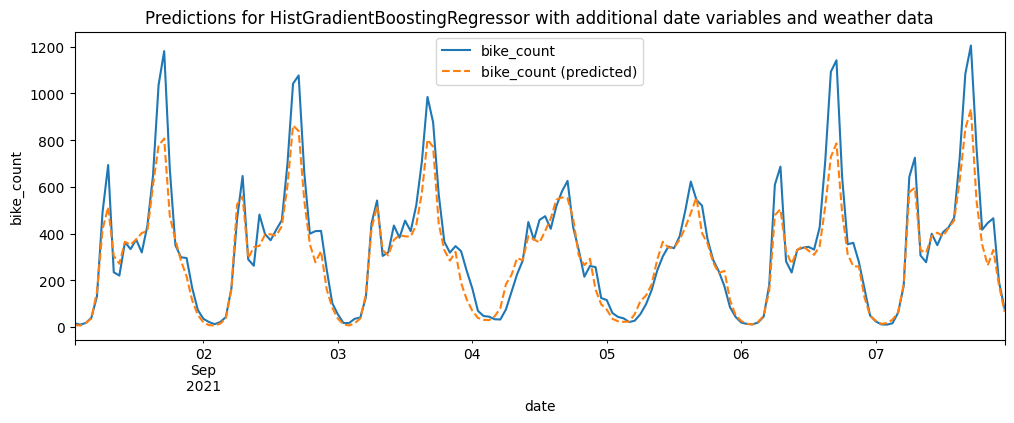

In [42]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "HistGradientBoostingRegressor with additional date variables and weather data",
)

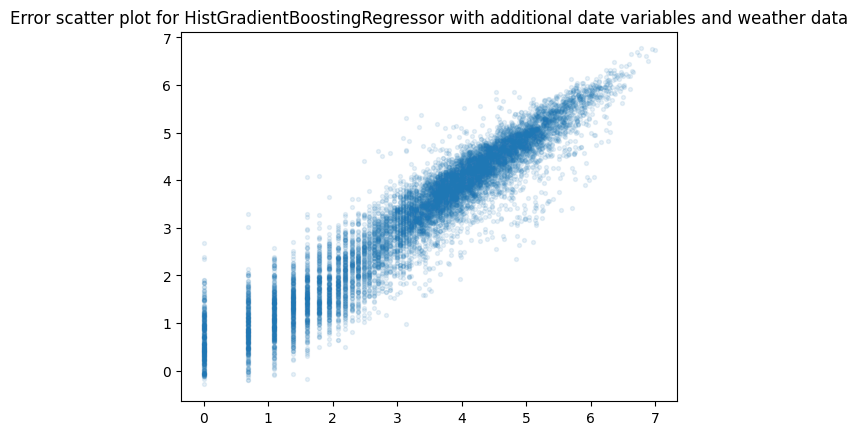

In [43]:
problem.error_plot(
    y_pred_test,
    y_test,
    "HistGradientBoostingRegressor with additional date variables and weather data",
)